# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

<font size="4"><strong>Reviews

<font size="4">Importamos los datos de reviews pero como es un dataset muy grande solo tomamos la tercera parte por ello el parametro de n=3. Inicialmente iniciamos el proceso cn un n=10 pero el resultado fu eun dataset con muchso usuarios que habian jugado una sola vez un juego con lo cual para el ejercicio del sistema de recomendacion no era un dataset valido.

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

<font size="4">Como el dataset es muy grande me genero un backup por si lo arruino durante el proceso

In [4]:
data_reviews_bkp=data_reviews.copy()
data_reviews_bkp.head(1)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN


In [5]:
# Solo para emergencias!!
data_reviews=data_reviews_bkp.copy()

## PARTE A: Análisis exploratorio de datos

<font size="4"><strong>Games

<font size="4">Importamos el dataset de juegos. Como no es un dataset grande lo tomamos directamente en el 100% 

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

<font size="4"><strong>Análisis de los atributos de cada dataset

In [7]:
data_reviews.head(2)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN


In [8]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


<font size="4"><strong>Análisis de valores Faltantes

In [9]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

<font size="4">Si bien existen varios atributos con muchos  valores faltantes. Es importante que no existan valores faltantes en el atributo <strong> product_id </strong> dado que es el atributo que hace el "join" con el dataset data_games que cuenta con los datos de los juegos. Si deberemos trabajar con el atributo <strong>user_id</strong> pues es mandatorio que por cada "producto_id" tengamos un "user_id" para poder evaluar el modelo. El resto de las columnas con valores faltantes no son necesarias y las eliminaremos del dataframe. 

<font size="4"><strong>¿Cómo tratar los faltantes en user_id?

<font size="4">Podriamos agrupar el dataset por nombre de usuario y ver si al menos una vez cada usuario tiene su ID. De ser asi podriamos utilizar esa tabla y reemplazar en el dataset original


In [10]:
user_analisis=data_reviews[['username','user_id']]
user_analisis

,username,user_id
0,Chaos Syren,NaN
1,Ariman1,NaN
2,freakfantom,NaN
3,The_Cpt_FROGGY,76561198003030375
4,the_maker988,76561198353396844
...,...,...
779302,Vidaar,NaN
779303,Nikolai Belinski,NaN
779304,RancorZealot,76561197963920623
779305,Jerry,76561198042664856


In [11]:
user_analisis.groupby(by='username').count()

,user_id
username,
!,1
! ZerZ,2
! ! ŦŕĩŽǿЯëќ™ ! !,0
! Alga,2
! DeadlyDeal !,0
...,...
󰀓Heavy Unit󰀓,0
󰀓Oxymoronicphalanx󰀓,0
󰀕 Africa's Population 󰀕,0


<font size="4">Para validad la idea creamos un nuevo dataset llamado <strong>user_analisis</strong> que solo contenga dos atributos "username" y "user_id" luego lo agrupamos por el atributo "username" y contamos la cantidad de ID por nombre de usuarios. Para poder aplicar la estrategia antes descripta deberíamos tener en todas las filas del resultado al menos un valor en la columna user_id, lo que indicaría que al menos una vez el usaurio tiene el ID registrado en el dataset. Si esto no es así  no podremos utilizar esta estrategia. Y por lo que se ve claramente hay usuarios que nunca tienen registrado su user_id con lo cual deberemos ir por el plan B: <strong> Generar un ID único para cada usuario </strong>

<font size="4"><strong>Eliminamos las columnas que no usaremos

<font size="4">Antes de seguir dejaremos el dataset más liviano eliminando las columnas que no nos sirven

In [12]:
data_reviews.drop(['date', 'products','page_order','text','early_access','compensation','found_funny','page', 'user_id'], axis=1, inplace=True)

In [13]:
data_reviews.head(2)

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100


<font size="4">Construimos un dataset nuevo con la lista de usuarios única más el nuevo ID generado

In [14]:
import numpy as np
usuarios=data_reviews['username'].unique()
usr_unico=pd.DataFrame(usuarios,columns=['username'])   
finRango=len(usr_unico)+1
user_id=np.array(range(1,finRango,1))
usr_unico['user_id']=user_id
usr_unico


,username,user_id
0,Chaos Syren,1
1,Ariman1,2
2,freakfantom,3
3,The_Cpt_FROGGY,4
4,the_maker988,5
...,...,...
540336,Seikleja,540337
540337,KindAlcoholic,540338
540338,SepticFalcon,540339
540339,RancorZealot,540340


<font size="4">Agregamos la columna a "data_reviews"

In [15]:
data_reviews=data_reviews.merge(usr_unico, left_on='username', right_on='username')

In [16]:
data_reviews

,username,hours,product_id,user_id
0,Chaos Syren,0.1,725280,1
1,Ariman1,13.2,328100,2
2,Ariman1,0.5,521230,2
3,Ariman1,2.0,493980,2
4,freakfantom,0.1,725280,3
...,...,...,...,...
779302,Seikleja,80.8,252490,540337
779303,KindAlcoholic,1303.6,252490,540338
779304,SepticFalcon,334.9,252490,540339
779305,RancorZealot,203.5,252490,540340


<font size="4"><strong>NaN Resueltos, y que pasa con la columna ¿Ranking?

<font size="4">Hasta aquí hemos resuelto los valores faltantes en "user_id" ahora el problema que debemos resolver es la columna de ranking. Pues el dataset no cuenta con una columna de ranking. Si cuenta con una columna de horas jugadas, con lo cual luego de pensar varias horas y ensayar cosas decidimos crear un ranking en base a las horas jugadas

<font size="4"><strong>1.Hagamos un primer analisis de la columna"hours" a ver como se distribuye*** 

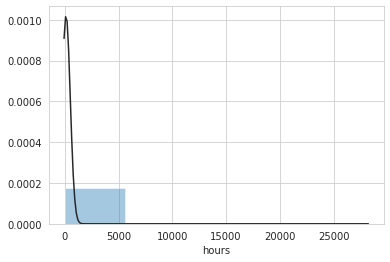

In [17]:
import seaborn as sns
from scipy.stats import norm
sns.set_style("whitegrid")
x = data_reviews.hours
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

<font size="4">En un primer análisis rápido pareciera como que las horas mayores a 100 podrían ser outliers que podrían ser tratados con por ejemplo el método de rangos intercuartilicos, pero también pueden ser valores extremos útiles y no necesariamente outliers. Parsa saberlo vamos a cuantificarlos

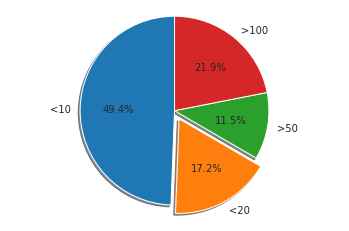

In [18]:
menorQue10=len(data_reviews[data_reviews.hours<10])
menorQue20=len(data_reviews[(data_reviews.hours>10)&(data_reviews.hours<20)])
mayorQue50=len(data_reviews[(data_reviews.hours>50)&(data_reviews.hours<100)])
mayoresQue100=len(data_reviews[data_reviews.hours>100])


import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['<10', '<20', '>50', '>100']
sizes = [menorQue10, menorQue20, mayorQue50, mayoresQue100]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Claramente no podemos tratar esos valores extremos como outliers. Pues representan casi el 22% de los datos. Perderíamos mucho sacándolos. Lo que haremos entonces es definir un escalado de datos de modo de transformar esas horas en un valor de rating. de 1 a 10.

<font size="4"><strong>2. Generamos la columna rating

In [19]:
# Agregao una columna denominada "rating" toda en valor cero.

data_reviews['rating']=0
data_reviews.head(1)

,username,hours,product_id,user_id,rating
0,Chaos Syren,0.1,725280,1,0


In [20]:
rank=[10,20,30,40,50,60,70,80,90]

for valor in rank:
    data_reviews['rating'][(data_reviews.hours>(valor-10)) & (data_reviews.hours<=valor)]=(valor/10)

data_reviews['rating'][(data_reviews.hours>=100) ]=10



<ipython-input-20-6df6932cb948>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews['rating'][(data_reviews.hours>(valor-10)) & (data_reviews.hours<=valor)]=(valor/10)
<ipython-input-20-6df6932cb948>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews['rating'][(data_reviews.hours>(valor-10)) & (data_reviews.hours<=valor)]=(valor/10)


In [21]:
# Elimino la columna hours pues ya no la necesito mas
data_reviews.drop(columns=['hours'], inplace=True)

<font size="4"><strong>Ahora sí!. Los NaN y la columna rating están resueltas

<font size="4">Vamos a ver de que forma nos quedó la distribución del ranking. Evidentemente la mayoria de los juegos están entre 1 y 4 , y también hay un gran porcentaje en 10 de rating, es decir que jugaron más de 100 horas.

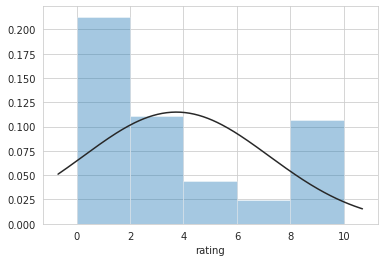

In [22]:
import seaborn as sns
from scipy.stats import norm
sns.set_style("whitegrid")
x = data_reviews.rating
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

<font size="4">Volvemos a hacer un gráfico de torta para ver bien como se reparten los valores del ranking

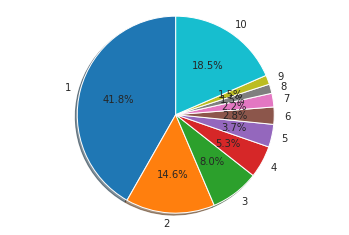

In [23]:
r1=len(data_reviews[data_reviews.rating==1])
r2=len(data_reviews[data_reviews.rating==2])
r3=len(data_reviews[data_reviews.rating==3])
r4=len(data_reviews[data_reviews.rating==4])
r5=len(data_reviews[data_reviews.rating==5])
r6=len(data_reviews[data_reviews.rating==6])
r7=len(data_reviews[data_reviews.rating==7])
r8=len(data_reviews[data_reviews.rating==9])
r9=len(data_reviews[data_reviews.rating==9])
r10=len(data_reviews[data_reviews.rating==10])
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [24]:
data_reviews.isna().sum()

username      0
product_id    0
user_id       0
rating        0
dtype: int64

## Análisis de "data_games"

In [25]:
data_games.head(1)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN


<font size="4">Analizamos los valores faltantes

In [26]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

<font size="5">Análisis de los atributos

<font size="4">De los atributos del dataset sólo dejaremos las columnas que para nuestro análisis son significativas estas son:
    
+ <font size="4">app_name
+ <font size="4">id ( que prepresenta el product_id)

<font size="4">El resto de las columnas a los fines de la predicción no son necesarias, al menos para este trabajo. Incluso la columna "title" la cual es igual a la columna"app_name" y además cuenta con muchos valores faltantes. Con lo cual nos quedaremos solo con la columna "app_name"

In [27]:
# Elimino la columna que no usaremos
data_games.drop(columns=['title','publisher','genres','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], inplace=True)

In [28]:
data_games.head()

,app_name,id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570


In [29]:
data_games.describe()

,app_name,id
count,32133,32133
unique,32094,32132
top,Soundtrack,612880
freq,3,2


Analizamos valores faltantes

In [30]:
data_games.isna().sum()

app_name    2
id          2
dtype: int64

<font size="4">Dado que sólo hay dos filas con valores faltantes eliminamos esas dos filas. 

In [31]:
data_games.dropna(inplace=True)

In [32]:
data_games.isna().sum()

app_name    0
id          0
dtype: int64

<font size="4">El último paso es renombrar la columna "id" a "product_id" para que se llame del mismo modo que en el dataset "data_reviews".

In [33]:
data_games.rename(columns={'id': 'product_id'}, inplace=True)
data_games

,app_name,product_id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570
...,...,...
32130,Colony On Mars,773640
32131,LOGistICAL: South Africa,733530
32132,Russian Roads,610660
32133,EXIT 2 - Directions,658870


<font size="4">***Trabajo Terminado*** El datasset <strong> data_games </strong> está listo para cumplir su función en este modelo.

## Hipotesis

Luego de hacer el análisis exploratorio de datos, nos encontramos con un dataset con muchas instancias y dentro de ese dataset muchas instancias de usuarios que solo evaluaron un solo juego. Por lo que sabemos del método que vamos a utilizar para predecir  basado en la <strong> matriz de factorización probabilística </strong>, estos métodos no performan bien con datasets grandes y tampoco con matrices de referencia pobladas de usuarios que hayan realizado pocas evaluaciones, pocos "likes". En base a esto vamos a quedarnos solo con los usuarios que tengan mas de valor 5 en el ranking que para el caso nuestro son usuarios que evaluaron más de 50 veces. Suponiendo que esto nos va a dar una mejor predicción y por otro lado reducirá el tamaño del dataset de entrenamiento lo que también debería mejorar la predicción. 

Fuente: <url>http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf</url>

 
## Parte B: Análisis con Surprice
 

<font size="5">Seleccion de la metrica

<font size="4">En base a la teoría sabemos que el RMSE es un buen predictor cuando el rango de diferencia entre los errores es pequeño, cuando no es así el MAE se comporta mejor. En el caso de nuestro ejemplo es posible que la diferencia entre los errores calculados sea de 2 o 3 puntos entre si con lo cual es posible que el RMSE los castigue mucho y por eso trabajaremos con el MAE. EL cual en este caso nos debería dar un valor más certero

<font size="4">Ahora que tenemos todos los datasets listos procederemos a entrenar y predecir con la bilioteca "Surprice". El primer paso es importar las librerías.

In [79]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


<font size="4"> El primer paso  es crear una instancia de la clase "reader" de surprice, indicandole en sus hiperparámetros en la escala de la columna "rating". Dado que nuestro rango va de 1 a 10 si dejáramos el rango por default qu eva de 1 a 5 la ejecución del modelo no seria del todo buena.

In [80]:
reader = Reader(rating_scale=(1, 10)) # Esta libreria se usa para parsear un archivo de rating que debe tener la forma de user ; item ; rating ; [timestamp] https://surprise.readthedocs.io/en/stable/reader.html

<font size="4"><strong>Creamos el dataset de surpriseen base a "data_reviews".

<font size="4">En base a lo que hemos visto del dataset "data_review" hay muchos usuarios que parecieran haber rankeado una sola vez o dos y del punto de vista del modelo no seria tan bueno entrenar con estas instancias. Pero para estar seguros vamos a analizar el dataset contando por cada usurio la cantidad de instancias. 

In [81]:
filtro=data_reviews[['user_id','product_id','rating']].groupby(by='user_id').count()
filtro

,product_id,rating
user_id,,
1,1,1
2,3,3
3,1,1
4,27,27
5,1,1
...,...,...
540337,1,1
540338,1,1
540339,1,1


<font size="4">Nos quedaremos con todos aquellos usuarios que hayan rankeado mas de 5 veces.


8962


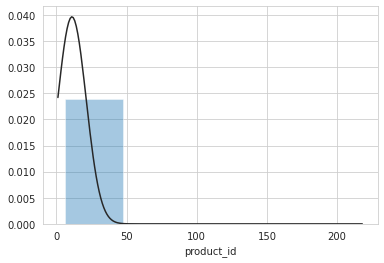

In [82]:

filtro=filtro[(filtro.product_id>5) ]
print(len(filtro))
sns.set_style("whitegrid")
x = filtro.product_id
ax = sns.distplot(x, fit=norm, kde=False, bins=5)
 

In [83]:
filtro_usuarios=pd.DataFrame(filtro)
filtro_usuarios

,product_id,rating
user_id,,
4,27,27
11,30,30
12,13,13
13,7,7
16,63,63
...,...,...
387888,6,6
392638,6,6
403065,6,6


In [84]:
filtro= filtro.rename_axis('user_id').reset_index()

In [85]:
filtro

,user_id,product_id,rating
0,4,27,27
1,11,30,30
2,12,13,13
3,13,7,7
4,16,63,63
...,...,...,...
8957,387888,6,6
8958,392638,6,6
8959,403065,6,6
8960,405132,6,6


<font size="4">Vamos a graficar con un gráfico de torta la distribución del rating. Si bien se podría hacer con un histograma este tipo de gráficas es más claro en cuanto a la distrbución. Para hacerlo usamos una variable por cada rating pues si le diéramos todo el dataset para procesar tardaría mucho tiempo.


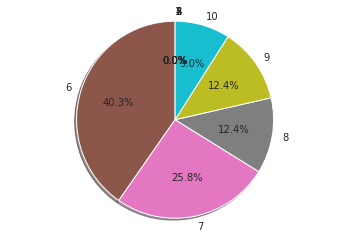

In [86]:
r1=len(filtro[filtro.rating==1])
r2=len(filtro[filtro.rating==2])
r3=len(filtro[filtro.rating==3])
r4=len(filtro[filtro.rating==4])
r5=len(filtro[filtro.rating==5])
r6=len(filtro[filtro.rating==6])
r7=len(filtro[filtro.rating==7])
r8=len(filtro[filtro.rating==9])
r9=len(filtro[filtro.rating==9])
r10=len(filtro[filtro.rating==10])
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<font size="4">Definimos un dataset nuevo denominado "grupo de usuarios filtrados" donde sólo constan los usaurios que jugaron más de cinco juegos al menos. <strong> Hacemos esto para mejorar la prediccion </strong> pues en base a nuestra hipotesis si dejamos los usuarios que jugaron mas veces la matriz de referencia estara nutrida de valores mas significativos, por otro lado reducimos el dataset del modelo lo que mejora tambien la perfomance del modelo

In [87]:
grupo_usuarios=filtro['user_id'].values
data_reviews_filtrado=data_reviews[data_reviews.user_id.isin(grupo_usuarios) ]
data_reviews_filtrado


,username,product_id,user_id,rating
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1
8,The_Cpt_FROGGY,493540,4,1
9,The_Cpt_FROGGY,341980,4,1
...,...,...,...,...
650193,Zaon,221910,418459,3
650194,Zaon,8930,418459,10
650195,Zaon,285310,418459,4
650196,Zaon,403640,418459,4


In [88]:
data = Dataset.load_from_df(data_reviews_filtrado[['user_id', 'product_id', 'rating']], reader)

In [89]:
data

<font size="4">Creamos una instancia de surprise.

In [90]:
from surprise import SVD
algo = SVD()

<font size="5">Selección de hiperparámetro con grid search

<font size="4"> Corremos grid search, para optimizar hiperparámetros. Volvemos a poner el hiperparámetro "n_factors" sólo para validar que la selección del modelo de "corss validation" fue bueno.

In [91]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1,10,15,20,50],'n_epochs': [5, 10,20,30], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['MAE'], cv=5, n_jobs = -1)
gs.fit(data)

In [92]:
print(gs.best_score['mae'])
print(gs.best_params['mae'])

1.875592330511358
{'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


<font size="5">Optimización de hiperparámetros terminada!

<font size="4"> vamos a correr el modelo con los hiperparámetros propuestos.

<font size="5">Separamos en el set de train y de test

In [93]:
trainset, testset = train_test_split(data, test_size=.33)

<font size="4">Creamos una instancia del modelo con los hiperparámetros propuestos.

In [95]:
from surprise import SVD
algo = SVD(n_factors =20,n_epochs=30,lr_all=0.005,reg_all=0.4 ) 

<font size="4">Hacemos el FIT del modelo

In [96]:
algo.fit(trainset)

In [97]:
predictions = algo.test(testset)

<font size="4">Exploramos un usuario a ver qué películas le gustan y cuáles le recomienda. Para ello seleccionamos un usuario cualquiera al azar

In [98]:
usuario = 418459
rating = 1 
# Filtramos data_reviews
df_user = data_reviews_filtrado[(data_reviews_filtrado['user_id'] == usuario) & (data_reviews_filtrado['rating'] >= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=data_games, left_on='product_id', right_on='product_id')
# Listamos el resultado
df_user

,username,product_id,user_id,rating,app_name
0,Zaon,313160,418459,3,Farming Simulator 15
1,Zaon,221910,418459,3,The Stanley Parable
2,Zaon,8930,418459,10,Sid Meier's Civilization® V
3,Zaon,285310,418459,4,RollerCoaster Tycoon®: Deluxe
4,Zaon,403640,418459,4,Dishonored 2
5,Zaon,391540,418459,10,Undertale


<font size="4">Creamos un dataframe  donde vamos a guardar las recomendaciones

In [99]:
recomendaciones_usuario =data_games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32132, 1)


,app_name
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge


<font size="4">Sacamos del dataframe todas las películas que ya sabemos que vio

In [100]:
usuario_vistas = data_reviews_filtrado[data_reviews_filtrado['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(6, 4)


,username,product_id,user_id,rating
650192,Zaon,313160,418459,3
650193,Zaon,221910,418459,3
650194,Zaon,8930,418459,10
650195,Zaon,285310,418459,4
650196,Zaon,403640,418459,4


<font size="4">Eliminamos las películas vistas del dataframe de recomendaciones, para que no vuelva a recomendarme  una pelicula que ya vio.

In [101]:
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()


,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


<font size="4">Generamos las recomendaciones mediante una función "lambda" que va recorriendo el dataset de recomendaciones y calculando la predicción

In [102]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

<font size="4">Listamos las diez mejores recomendaciones

In [103]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,app_name,Estimate_Score
22837,394360,Hearts of Iron IV,8.091723
853,203770,Crusader Kings II,8.011593
387,48700,Mount & Blade: Warband,7.902100
2804,250900,The Binding of Isaac: Rebirth,7.819828
1043,730,Counter-Strike: Global Offensive,7.774045
31249,105600,Terraria,7.720341
29477,39210,FINAL FANTASY XIV Online,7.590753
24349,311310,Naval Action,7.568121
3342,304030,ArcheAge,7.564453
7291,385760,NBA 2K17,7.473598


<font size="4">Calculamos el RMSE  de la recomendación

In [104]:
from surprise import accuracy 
accuracy.mae(predictions, verbose=True)

MAE:  1.9178


1.9177756594458941

In [105]:
accuracy.rmse(predictions, verbose=True)

RMSE: 2.5494


2.5494273534647505

<font size="5">Comprobacion de la hipotesis</font>

<font size="4"> Vamos a evaluar el mismo modelo, con los mismos hiperparametros propuestos pero tomando como dataset de entrenamiento aquellos usuarios con menos recomendaciones de juegos realizadas. Si la hipotesis es correcta el error del modelo deberia incrementarse</font>

In [106]:
# Filtramos los datos tomando aquellos usuarios que tienen rating menor a 5 esot es menos de 50 recomendaciones.
filtro=data_reviews[['user_id','product_id','rating']].groupby(by='user_id').count()
filtro=filtro[(filtro.product_id<5) ]
filtro_usuarios=pd.DataFrame(filtro)
filtro= filtro.rename_axis('user_id').reset_index()
grupo_usuarios=filtro['user_id'].values
data_reviews_filtrado=data_reviews[data_reviews.user_id.isin(grupo_usuarios) ]
#Entrenamos
data = Dataset.load_from_df(data_reviews_filtrado[['user_id', 'product_id', 'rating']], reader)
algo = SVD()
trainset, testset = train_test_split(data, test_size=.33)
from surprise import SVD
algo = SVD(n_factors =15,n_epochs=30,lr_all=0.005,reg_all=0.4 ) 
algo.fit(trainset)
predictions = algo.test(testset)

# Seleccionamos el mismo usuario que en el ejemplo anterior
usuario = 418459
rating = 1 
# Filtramos data_reviews
df_user = data_reviews_filtrado[(data_reviews_filtrado['user_id'] == usuario) & (data_reviews_filtrado['rating'] >= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=data_games, left_on='product_id', right_on='product_id')
recomendaciones_usuario =data_games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
usuario_vistas = data_reviews_filtrado[data_reviews_filtrado['user_id'] == usuario]
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario.head(10)
accuracy.mae(predictions, verbose=True)

MAE:  2.3244


2.324449560739946

In [107]:
recomendaciones_usuario.head(10)

,product_id,app_name,Estimate_Score
0,761140,Lost Summoner Kitty,3.857308
1,643980,Ironbound,3.804228
2,670290,Real Pool 3D - Poolians,3.207811
3,767400,弹炸人2222,3.857308
4,773570,Log Challenge,3.857308
5,772540,Battle Royale Trainer,3.208503
6,774276,SNOW - All Access Basic Pass,3.857308
7,774277,SNOW - All Access Pro Pass,3.857308
8,774278,SNOW - All Access Legend Pass,3.857308
9,768800,Race,3.857308


<font size="5">Interpretacion<font/>

<font size="4"><strong>1. La hipotesis planteada inicialmente se comprueba:</strong> Claramente el error crece al utilizar usuarios con pocas recomendaciones. Si nos fijamos las recomendaciones en la columna de score estimado el score disminuye drasticamente con lo cual el riesgo de proponer un juego que no le guste al usuario es grande.<font/>

<font size="4"><strong>2. La seleccion de lametrica de evaluacion del modelo es correcta:</strong> Se puede ver claramente que la predicciondel RMSE tiene mas error que la del MAE. Y esto tiene que ver con lo que planteabamos inicialmente respecto de que la diferencia entre los errores no es proxima y en esta situacion el RMSE castiga mucho al error por el hecho de elevarlo al cuadrado. MAE para este caso es una metrica que describe mejor el error y la exactitud de la preduccion.

## Parte C: Investigación

<font size=4><strong>Proximos pasos:</strong> Aplicar tecnicas de lenguaje natural para mejorar la prediccion

<font size=4><strong>Justificacion:</strong>En el trabajo anterior en base a las horas jugadas inferimos un rating. Cosa que no esta mal pero que tampoco esta del todo bien. Si analizamos el dataset <strong>data_reviews</strong> encontraremos un atributo <strong>text</strong> donde el usaurio coloca una descripcion de su experiencia con el juego. Incluso ese atributo no presenta valores nulos con lo cual si analizamos con tecnicas de lenguaje natural ese campo de texto  e inferimos el gusto por el juego seguramente podremos lograr reglas de ranking mas orientadas al gusto real del usaurio.


In [112]:
data_reviews_bkp.head(10)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN
5,Szudof,0.2,155.0,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",False,1,NaN,Product received for free,3.0
6,Vonder,2.7,264.0,35600,3,2017-04-15,I like the art style and the idea but what a b...,False,1,76561198113497324,NaN,NaN
7,LucaFox,4.0,136.0,620900,3,2017-09-11,"Very, very good game. I love dungeon crawlers,...",False,1,76561198146674484,NaN,1.0
8,rampage1209,34.8,3.0,1840,4,2018-01-04,WAY PAST COOL,False,1,76561198080474371,NaN,NaN
9,Devil Azite,0.1,548.0,671270,5,2017-07-09,Putting a hat on your head has disasterous rep...,False,1,NaN,Product received for free,1.0


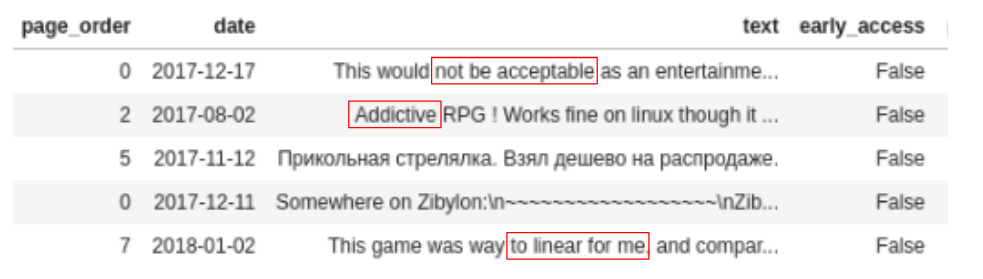

Adicionalmente en el dataset <strong>data_games</strong> existen atributos como el atributo <strong>tags</strong> que tiene poco valoresnulos y que identifica el genero del juego que combinado con el dataset <strong>data_reviews</strong> nos permitiria inferir no solo los gustos del usuario sino el genero y a partir de el pensar algun tipo de modelo mas complejo.

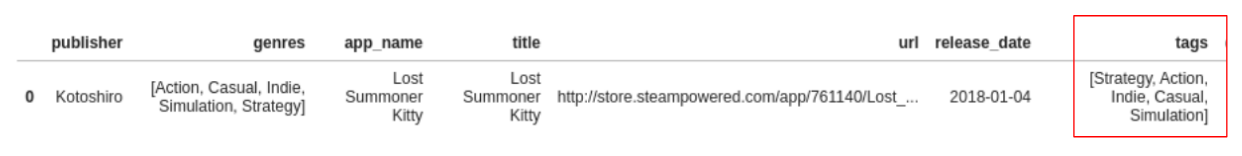

<font size=4><strong>Resultado esperado:</strong> El resultado esperado de este trabajo es lograr una mejor prediccion no tanto desde el punto de vista del MAE o de la metrica. Pero si  desde el gusto del usaurios, es decir que sea mas realista qie la prediccionbasada enhoras jugadas. Porque de pronto las horas jugadas, si el usuario se olvido el juego en linea pero no estaba jugando van a sumar pero no necesariamente queire decir que al usuario le gusto. En cambio el analisis del comentario arrojara valores mas reales de los gustos.

## Link de GitHub

<url>https://github.com/dgiacone/AcamicaSistemaRecomendacion</url>
